In [39]:
import pandas as pd
from datetime import datetime

In [40]:
def windows_ui_language_tag():
    import sys
    if not sys.platform.startswith("win"):
        return None
    import ctypes, locale
    langid = ctypes.windll.kernel32.GetUserDefaultUILanguage()
    return locale.windows_locale.get(langid)  # e.g., 'en_US' or 'es_ES'

print(windows_ui_language_tag())


None


In [41]:
from config.config_loader import Config


config = Config()

In [42]:
path_alias_elec = config.get_resolved_path("data_path.elec.customers.alias_elec")
path_load_parquet = config.get_resolved_path("data_path.elec.processed.load_parquet")
path_facturas_elec = config.get_path("data_path.elec.processed.facturas")
path_facturas_elec_manual = config.get_resolved_path("data_path.elec.processed.facturas_manual")

In [43]:
df_alias_elec = pd.read_excel(path_alias_elec)
df_load = pd.read_parquet(path_load_parquet)

In [44]:
alias_df_fil = df_alias_elec[df_alias_elec['cliente'] == 'Taghleef']
# alias_df_fil = alias_df_fil[
#                     # # (~alias_df_fil['alias'].isin(['HQ1','HQ2','HQ3', 'VELERIN'])) &
#                     (alias_df_fil['alias'].isin(['WARNER BS']))
#                     &
#                     ((alias_df_fil['cups'] != 'ES0022000009138571BZ'))
#                     ]
len(alias_df_fil['cups'].values)

len(alias_df_fil['cups'].to_list())
alias_df_fil

,cliente,alias,cups,tarifa,electrointensivo,contrato
24,Taghleef,TAGHLEEF,ES0031101457946001KR,6.1 TD,True,1


In [45]:
df_facturas_elec_manual = pd.read_pickle(path_facturas_elec_manual)

In [46]:
from sqlalchemy import create_engine

engine = create_engine(f'sqlite:///{path_facturas_elec}', echo=True)
df_facturas_elec = pd.read_sql(('SELECT * FROM facturas'), con=engine)

for column in ['inicio_periodo', 'fin_periodo', 'issue_date']:
        df_facturas_elec[column] = pd.to_datetime(df_facturas_elec[column])

df_facturas_elec.sort_values(by=['issue_date', 'cups'], ascending=False, inplace=True)

df_facturas_elec = pd.concat([df_facturas_elec, df_facturas_elec_manual], ignore_index=True)

2025-08-25 17:47:30,102 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-08-25 17:47:30,103 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM facturas")
2025-08-25 17:47:30,104 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-08-25 17:47:30,105 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM facturas")
2025-08-25 17:47:30,105 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-08-25 17:47:30,106 INFO sqlalchemy.engine.Engine SELECT * FROM facturas
2025-08-25 17:47:30,106 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-08-25 17:47:30,157 INFO sqlalchemy.engine.Engine ROLLBACK


['ES0031101457946001KR']


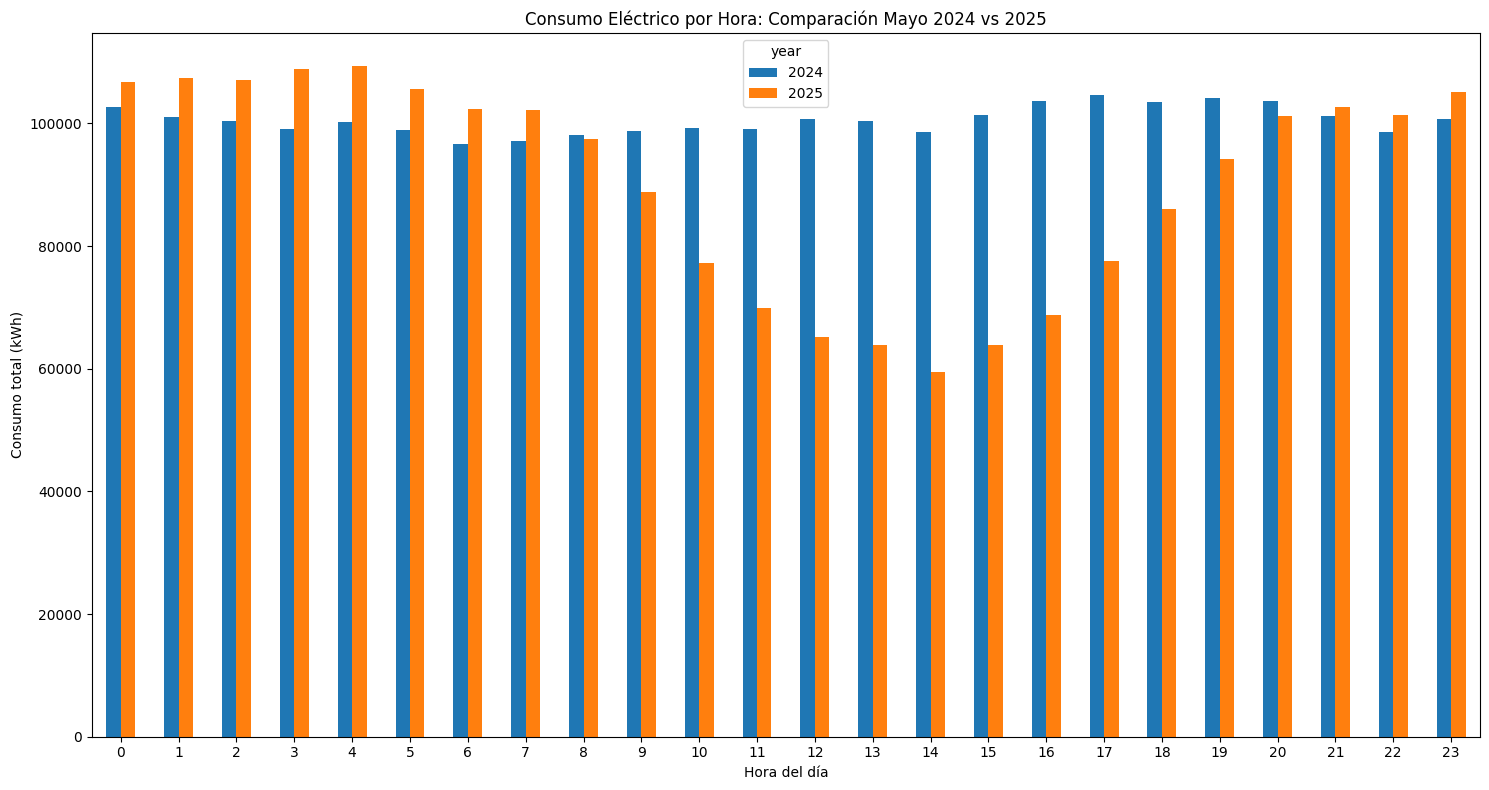

In [47]:
# cups = 'ES0021000013002530NY'
cups_list = alias_df_fil['cups'].values
print(cups_list)
df_filtered = df_load[
                # (df_load['datetime'] >= datetime(2024,6,1,0,0,0)) 
                # & 
                # (df_load['datetime'] <= datetime(2025,5,31,23,0)) 
                # &
                # (df_load['cups'].isin(['ES0022000009138573BQ', 'ES0022000009138572BS', 'ES0022000008103260DW'])) 
                # & 
                (df_load['cups'].isin(cups_list)) 
                &
                # (df_load['cups'] == cups) 
                # &
                # (df_load['cliente'] == 'Taghleef') 
                # # &
                (df_load['datetime'].dt.month.isin([5])) 
                &
                (df_load['datetime'].dt.year.isin([2024,2025])) 
                &
                (df_load['resolution'] == 'hourly')
                # &
                # (df_load['file'] == 'load_creara20250102_114014.pkl')                
                ]

df_filtered = df_filtered.copy()

df_filtered['year'] = df_filtered['datetime'].dt.year
df_filtered['hour'] = df_filtered['datetime'].dt.hour

# Paso 2: Agrupar por año y hora para obtener el consumo total por hora
hourly_consumption = df_filtered.groupby(['year', 'hour'])['load'].sum().reset_index()

# Paso 3: Crear una tabla pivote para facilitar el plotting
pivot_data = hourly_consumption.pivot(index='hour', columns='year', values='load')

# Paso 4: Crear el gráfico de barras agrupadas
pivot_data.plot(
    kind='bar',
    figsize=(15, 8),
    title='Consumo Eléctrico por Hora: Comparación Mayo 2024 vs 2025',
    xlabel='Hora del día',
    ylabel='Consumo total (kWh)',
    legend=True,
    color=['#1f77b4', '#ff7f0e']  # Colores distintivos para cada año
)

import matplotlib.pyplot as plt

plt.xticks(rotation=0)  # Mantener las etiquetas de hora horizontales
plt.tight_layout()
plt.show()



In [50]:

df_facturas_elec_fil = df_facturas_elec[
        # (df_facturas_elec['inicio_periodo'] >= datetime(2024,1,1)) 
        # &
        # (df_facturas_elec['fin_periodo'] <= datetime(2024,12,31)) 
        # &
        # (df_facturas_elec['cups'].isin(alias_df_fil['cups'].values))
        # &
        (df_facturas_elec['alias'].isin(['TAGHLEEF']))
        &
        (df_facturas_elec['month'].isin([5]))
        &
        (df_facturas_elec['year'].isin([2024]))
        ]

# df_facturas_elec_fil = df_facturas_elec_fil.groupby(['cups']).last()
# df_facturas_elec_fil.reset_index(drop=False, inplace=True)

# potencia_list = [f'potencia_p{i}' for i in range(1,7)]
# print(potencia_list)
# df_facturas_elec_fil['alias'] = df_facturas_elec_fil['cups'].apply(
#     lambda x: df_alias_elec.loc[df_alias_elec['cups'] == x, 'alias'].iloc[0]
#     )
# df_facturas_elec_fil = df_facturas_elec_fil[['alias', 'cups'] + [f'potencia_p{i}' for i in range(1,7)]]
# df_facturas_elec_fil.to_excel(config.get_path('data_path.elec.temp.excel', name='Potencias contratadas PR'))



df_facturas_elec_fil.sort_values(by=['alias', 'year', 'month'], ascending=True, inplace=True)
df_facturas_elec_fil

/var/folders/h0/lxnrg5455xq4t849z7ztv_5r0000gn/T/ipykernel_35516/3086397242.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_facturas_elec_fil.sort_values(by=['alias', 'year', 'month'], ascending=True, inplace=True)


,num_factura,inicio_periodo,fin_periodo,issue_date,cups,coste_potencia,coste_energia,excesos_potencia,dto_electrointensivo,coste_reactiva,...,energia_p5,energia_p6,maximetros_p1,maximetros_p2,maximetros_p3,maximetros_p4,maximetros_p5,maximetros_p6,year,month
852,PA24142000021942,2024-05-01 00:00:00,2024-05-31 00:00:00,2024-09-02 00:00:00,ES0031101457946001KR,0.00,-957.50,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024,5
1056,PI24142000200254,2024-05-01 00:00:00,2024-05-31 00:00:00,2024-06-12 00:00:00,ES0031101457946001KR,21359.03,190381.08,768.81,-17260.57,0.0,...,495552.0,1281140.0,0.0,0.0,0.0,4256.0,4316.0,4288.0,2024,5


In [11]:
path_ssaa_c2_df = config.get_path("data_path.elec.processed.ssaa_df", mode='c2')
df_omie = pd.read_pickle(path_ssaa_c2_df)


df_omie.groupby([df_omie['datetime'].dt.year])[['ssaa']].mean().reset_index()


,datetime,ssaa
0,2018,5.968160
1,2019,4.620863
2,2020,4.959759
3,2021,5.526858
4,2022,32.504949
5,2023,11.650222
6,2024,12.038523
7,2025,17.146222


In [ ]:
path_ssaa_c2_df_dt = config.get_path("data_path.elec.processed.ssaa_df_detailed", mode='c2')
df_ssaa_dt = pd.DataFrame
df_ssaa_dt = pd.read_pickle(path_ssaa_c2_df_dt)
# df_ssaa_dt = df_ssaa_dt[df_ssaa_dt['datetime'].dt.year >=2023]
# df_ssaa_dt['periodo'] = df_ssaa_dt.apply(lambda row: df_omie[df_omie['datetime'] == row['datetime']]['periodo'].values[0], axis=1)

In [ ]:
df_ssaa_dt.groupby([df_ssaa_dt['datetime'].dt.year])['ssaa'].mean().reset_index().sort_values(by=['datetime'])

KeyError: 'Column not found: ssaa'

: 

In [ ]:
df_tag = pd.read_excel("ES0205170705367001GG.xlsx")
# If the column contains integers, convert to string first
df_tag['Fecha'] = pd.to_datetime(df_tag['Fecha'].astype(str), format='%Y%m%d')
df_tag.drop_duplicates(subset=['Fecha', 'Unidad de Medida'], inplace=True)

df_tag = df_tag.groupby(['Fecha'])['Energía (kWh)'].sum().reset_index()

df_tag.to_excel("Consumos diarios gas Taghleef.xlsx", index=False)

df_tag.groupby([df_tag['Fecha'].dt.year, df_tag['Fecha'].dt.month])['Energía (kWh)'].sum()

df_tag

,Fecha,Energía (kWh)
0,2024-05-01,55592.640
1,2024-05-02,54389.235
2,2024-05-03,51998.250
3,2024-05-04,47006.934
4,2024-05-05,49332.096
...,...,...
360,2025-04-26,25326.208
361,2025-04-27,27400.027
362,2025-04-28,8032.242
363,2025-04-29,24958.884
